# Machine Learning Graduation Task

https://www.kaggle.com/joniarroba/noshowappointments

**We proposed in the Web Engineering Final Project, a [Hospital Appointments Management System (HAMS)](https://morning-badlands-31060.herokuapp.com) . However, a patient may eventually not even show up for the appointment. Identifying potential no-shows can help healthcare institutions pursue targeted interventions (e.g. reminder phone calls, double-book an appointment slot) to reduce no-shows and financial loss. 
That's why, based on the dataset provided in Kaggle where 110.527 medical appointments are available, we will predict the ShowUp or NoShowUp to an appointment. This work will help us identify the best model for predicting the appointments show up/no show up based on the data of our platform (once deploy and operational)**.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import f1_score, confusion_matrix ,accuracy_score
from sklearn.metrics import precision_score, recall_score

## Dataset - Most important points

In [6]:
data = pd.read_csv('KaggleV2-May-2016.csv')
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [7]:
print('The dataset has', data.shape[0], 'rows and', data.shape[1], 'features')

The dataset has 110527 rows and 14 features


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


- Let's see if a patient is likely to miss an appointment again if he/she missed the previous one

In [9]:
data['No-show'] = data['No-show'].replace({'No':0, 'Yes':1})
missed_appointment = data.groupby('PatientId')['No-show'].sum()
missed_appointment = missed_appointment.to_dict()
data['missed_appointment_before'] = data.PatientId.map(lambda x: 1 if missed_appointment[x]>0 else 0)
data['missed_appointment_before'].corr(data['No-show'])

0.6298313265252282

- Let's check about the Gender

In [10]:
patients = data.drop_duplicates(subset=['PatientId'])
n_patients = patients.shape[0]
count = patients.Gender.value_counts()
n_women = count.values[0]
n_men = count.values[1]
print('Proportion of the dataset that are women: {0:2.1f}%'.format(100*n_women/n_patients))
print('Proportion of the dataset that are men: {0:2.1f}%'.format(100*n_men/n_patients))

Proportion of the dataset that are women: 64.3%
Proportion of the dataset that are men: 35.7%


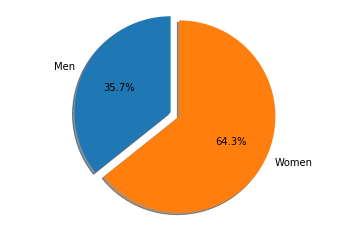

In [15]:
first = 100*n_women/n_patients
second = 100*n_men/n_patients

labels = 'Men', 'Women', 
sizes = [second, first]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

- Let's have two groups and see if the waiting time until the next appointment matter

In [16]:
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]
print('Do not miss appointments:{0: 2.2f}%'.format(100*n_show/data.shape[0]))
print('Miss appointments:{0: 2.2f}%'.format(100*n_no_show/data.shape[0]))

Do not miss appointments: 79.81%
Miss appointments: 20.19%


In [17]:
#Receives an integer representing the number of days until an appointment and returns the category it is in.
def map_waiting_interval_to_days(x):
    if x ==0 :
        return 'Less than 15 days'
    elif x > 0 and x <= 2:
        return 'Between 1 day and 2 days'
    elif x > 2 and x <= 7:
        return 'Between 3 days and 7 days'
    elif x > 7 and x <= 31:
        return 'Between 7 days and 31 days'
    else:
        return 'More than 1 month'

In [18]:
d = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data['mapped_AppointmentDay'] = data['AppointmentDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
data['mapped_ScheduledDay'] = data['ScheduledDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
data['waiting_interval'] = abs(data['mapped_ScheduledDay'] - data['mapped_AppointmentDay'])
data['waiting_interval_seconds'] = data['waiting_interval'].map(lambda x: x.seconds)
data['waiting_interval_days'] = data['waiting_interval'].map(lambda x: x.days)
data['waiting_interval_days'] = data['waiting_interval_days'].map(lambda x: map_waiting_interval_to_days(x))

data['ScheduledDay_month'] = data['mapped_ScheduledDay'].map(lambda x: x.month)
data['ScheduledDay_day'] = data['mapped_ScheduledDay'].map(lambda x: x.day)
data['ScheduledDay_weekday'] = data['mapped_ScheduledDay'].map(lambda x: x.weekday())

data['AppointmentDay_month'] = data['mapped_AppointmentDay'].map(lambda x: x.month)
data['AppointmentDay_day'] = data['mapped_AppointmentDay'].map(lambda x: x.day)
data['AppointmentDay_weekday'] = data['mapped_AppointmentDay'].map(lambda x: x.weekday())
data['AppointmentDay_weekday'] = data['AppointmentDay_weekday'].replace(d)

show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]

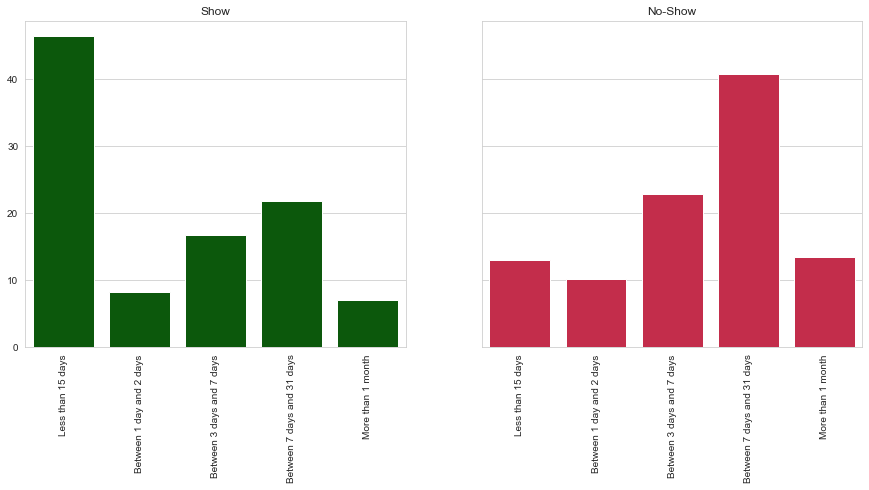

In [19]:
levels = ['Less than 15 days','Between 1 day and 2 days','Between 3 days and 7 days',
'Between 7 days and 31 days','More than 1 month']

grouped = show.groupby(by='waiting_interval_days')
count_days1 = grouped.waiting_interval_days.count().reindex(index = levels)
count_days1 = 100*count_days1/show.shape[0]

grouped = no_show.groupby(by='waiting_interval_days')
count_days2 = grouped.waiting_interval_days.count().reindex(index = levels)
count_days2 = 100*count_days2/no_show.shape[0]

sns.set_style("whitegrid")
f, ax = plt.subplots(1, 2,figsize=(15, 6),sharey=True)
g1 = sns.barplot(x=count_days1.index, y=count_days1.values, 
                color='darkgreen',ax=ax[0])
g1.set_xticklabels(levels, rotation=90);
g1.set_xlabel('');
g1.set_title('Show');
g2 = sns.barplot(x=count_days2.index, y=count_days2.values, 
                color='crimson',ax=ax[1])
g2.set_xticklabels(levels, rotation=90);
g2.set_xlabel('');
g2.set_title('No-Show');

- About the Age

In [20]:
#Receives an integer and returns the age category that this age is in.
def map_age(x):
    if x < 12:
        return 'Child'
    elif x > 12 and x < 18:
        return 'Teenager'
    elif x>=20 and x<25:
        return 'Young Adult'
    elif x>=25 and x<60:
        return 'Adult'
    else:
        return 'Senior'
data['mapped_Age'] = data['Age'].map(lambda x: map_age(x))
patients['mapped_Age'] = patients['Age'].map(lambda x: map_age(x))

/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


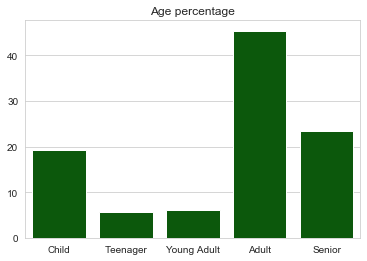

In [21]:
ages = ['Child','Teenager','Young Adult','Adult','Senior']
n_patients = patients.shape[0]
grouped = patients.groupby(by='mapped_Age')
count_ages = grouped.Age.count().reindex(index = ages)
g = sns.barplot(x=count_ages.index, y=count_ages.values*(100/n_patients), color='darkgreen');
g.set_title('Age percentage');
g.set_xlabel('');

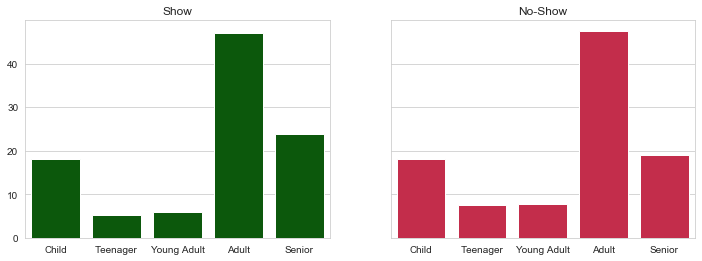

In [22]:
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]
ages = ['Child','Teenager','Young Adult','Adult','Senior']

# count ages for group which didnt miss appointment
grouped = show.groupby(by='mapped_Age')
count_ages1 = grouped.Age.count().reindex(index = ages)
count_ages1 = count_ages1*(100/show.shape[0])

# count ages for group which missed appointment
grouped = no_show.groupby(by='mapped_Age')
count_ages2 = grouped.Age.count().reindex(index = ages)
count_ages2 = count_ages2*(100/no_show.shape[0])

sns.set_style("whitegrid")
f, ax = plt.subplots(1, 2,figsize=(12, 4),sharey=True)
g1 = sns.barplot(x=count_ages1.index, y=count_ages1.values, 
            color='darkgreen',ax=ax[0])
g1.set_xlabel('');
g1.set_title('Show');
g2 = sns.barplot(x=count_ages2.index, y=count_ages2.values, 
            color='crimson',ax=ax[1]);
g2.set_xlabel('');
g2.set_title('No-Show');

* Diseases like Hipertension, Diabetes, ...

In [26]:
patients = data.drop_duplicates(subset=['PatientId'])
patients[['Hipertension','Diabetes','Alcoholism','Handcap']].sum(axis=0)/patients.shape[0]

Hipertension    0.196504
Diabetes        0.070884
Alcoholism      0.024174
Handcap         0.020113
dtype: float64

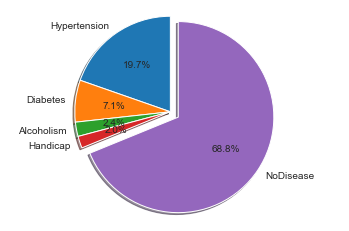

In [38]:
hyper = (patients['Hipertension'].sum(axis=0)/patients.shape[0])*100
diab = (patients['Diabetes'].sum(axis=0)/patients.shape[0])*100
alco = (patients['Alcoholism'].sum(axis=0)/patients.shape[0])*100
handi = (patients['Handcap'].sum(axis=0)/patients.shape[0])*100
rest = 100 - (hyper + diab + alco + handi)

labels = 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'NoDisease'
sizes = [hyper, diab, alco, handi, rest]
explode = (0, 0, 0, 0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [39]:
data['haveDisease'] = data.Alcoholism | data.Handcap | data.Diabetes | data.Hipertension

In [40]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,waiting_interval_seconds,waiting_interval_days,ScheduledDay_month,ScheduledDay_day,ScheduledDay_weekday,AppointmentDay_month,AppointmentDay_day,AppointmentDay_weekday,mapped_Age,haveDisease
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,...,67088,Less than 15 days,4,29,4,4,29,Friday,Senior,1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,...,58107,Less than 15 days,4,29,4,4,29,Friday,Adult,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,...,58744,Less than 15 days,4,29,4,4,29,Friday,Senior,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,...,62971,Less than 15 days,4,29,4,4,29,Friday,Child,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,...,58043,Less than 15 days,4,29,4,4,29,Friday,Adult,1


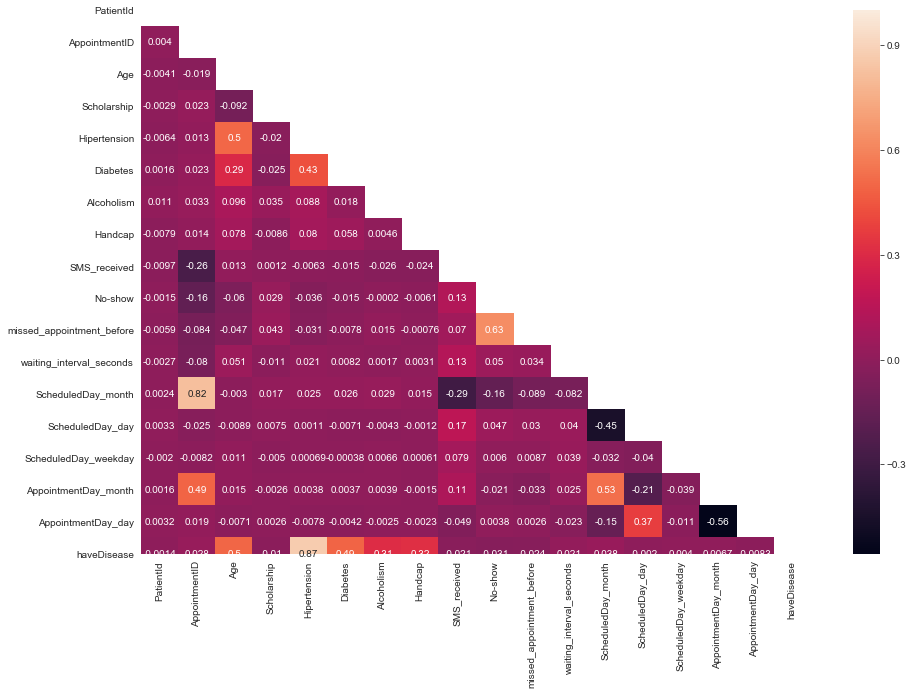

In [16]:
fig, ax = plt.subplots(figsize=[15,10])
#data = data.drop(columns=['AppointmentID', 'PatientId'])
cor=data.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, 
            annot=True, mask=mask);

## Data Prepapration

In [17]:
data.isnull().sum().any()

False

**There is no missing values**

In [18]:
#Receives the dataset, clean data and engineer new features. 
#Return cleaned dataset with features that will be used for training model.
def process_data(data):
    d = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    data['mapped_AppointmentDay'] = data['AppointmentDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    data['mapped_ScheduledDay'] = data['ScheduledDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    data['waiting_interval'] = abs(data['mapped_ScheduledDay'] - data['mapped_AppointmentDay'])
    data['waiting_interval_days'] = data['waiting_interval'].map(lambda x: x.days)
    data['waiting_interval_days'] = data['waiting_interval_days'].map(lambda x: map_waiting_interval_to_days(x))
    
    data['ScheduledDay_month'] = data['mapped_ScheduledDay'].map(lambda x: x.month)
    data['ScheduledDay_day'] = data['mapped_ScheduledDay'].map(lambda x: x.day)
    data['ScheduledDay_weekday'] = data['mapped_ScheduledDay'].map(lambda x: x.weekday())
    data['ScheduledDay_weekday'] = data['ScheduledDay_weekday'].replace(d)

    data['AppointmentDay_month'] = data['mapped_AppointmentDay'].map(lambda x: x.month)
    data['AppointmentDay_day'] = data['mapped_AppointmentDay'].map(lambda x: x.day)
    data['AppointmentDay_weekday'] = data['mapped_AppointmentDay'].map(lambda x: x.weekday())
    data['AppointmentDay_weekday'] = data['AppointmentDay_weekday'].replace(d)
    
    data['No-show'] = data['No-show'].replace({'Yes':1, 'No':0})
   
    missed_appointment = data.groupby('PatientId')['No-show'].sum()
    missed_appointment = missed_appointment.to_dict()
    data['missed_appointment_before'] = data.PatientId.map(lambda x: 1 if missed_appointment[x]>0 else 0)
    data['mapped_Age'] = data['Age'].map(lambda x: map_age(x))
    data['Gender'] = data['Gender'].replace({'F':0, 'M':1})
    data['haveDisease'] = data.Alcoholism | data.Handcap | data.Diabetes | data.Hipertension

    data = data.drop(columns=['waiting_interval', 'AppointmentDay', 'ScheduledDay',
                             'PatientId','Age', 'mapped_ScheduledDay',
                             'mapped_AppointmentDay', 'AppointmentID', 
                              'Alcoholism','Handcap','Diabetes','Hipertension'])
    
    return data

In [19]:
def one_hot_encode(data):
    return pd.get_dummies(data)

In [20]:
data = pd.read_csv('KaggleV2-May-2016.csv')
processed_data = process_data(data)
processed_data.head()

,Gender,Neighbourhood,Scholarship,SMS_received,No-show,waiting_interval_days,ScheduledDay_month,ScheduledDay_day,ScheduledDay_weekday,AppointmentDay_month,AppointmentDay_day,AppointmentDay_weekday,missed_appointment_before,mapped_Age,haveDisease
0,0,JARDIM DA PENHA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Senior,1
1,1,JARDIM DA PENHA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Adult,0
2,0,MATA DA PRAIA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Senior,0
3,0,PONTAL DE CAMBURI,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,1,Child,0
4,0,JARDIM DA PENHA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Adult,1


In [21]:
encoded_data = one_hot_encode(processed_data)
encoded_data.head()

,Gender,Scholarship,SMS_received,No-show,ScheduledDay_month,ScheduledDay_day,AppointmentDay_month,AppointmentDay_day,missed_appointment_before,haveDisease,...,AppointmentDay_weekday_Monday,AppointmentDay_weekday_Saturday,AppointmentDay_weekday_Thursday,AppointmentDay_weekday_Tuesday,AppointmentDay_weekday_Wednesday,mapped_Age_Adult,mapped_Age_Child,mapped_Age_Senior,mapped_Age_Teenager,mapped_Age_Young Adult
0,0,0,0,0,4,29,4,29,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,4,29,4,29,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,4,29,4,29,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,4,29,4,29,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,4,29,4,29,0,1,...,0,0,0,0,0,1,0,0,0,0


## Model

In [22]:
print('Accuracy: {:2.2f}%'.format(100 - (100*encoded_data['No-show'].sum()/encoded_data.shape[0])))

Accuracy: 79.81%


In [23]:
# row: true label ; columns: predictions
tn, fp, fn, tp = confusion_matrix(encoded_data['No-show'], np.zeros(encoded_data.shape[0])).ravel()
(tn, fp, fn, tp)

(88208, 0, 22319, 0)

We tried to predict class with majority (No-show==0) for all cases. The Naive Predictor gives almost 80 percent but it does not classify correctly any of out positivies entries. The 22319 false negatives (this model have poor recall). We want to retrieve individues that will miss the appointment (our True Positives) and also avoid classify persons that will show up as a no-show. We need a metric that takes precision and recall into consideration, therefore F1 score seems a good choice.

In [24]:
X = encoded_data.drop(columns='No-show')
y = encoded_data['No-show']
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.30, random_state=42)

print('Train size:{}'.format(X_train.shape))
print('Test size:{}'.format(X_test.shape))

Train size:(77368, 112)
Test size:(33159, 112)


**1. Random Forest Classifier**

In [26]:
clf1 = RandomForestClassifier(random_state = 0)
clf1.fit(X_train, y_train)
y_preds = clf1.predict(X_test)

/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
print('Random Forest - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('Random Forest - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('Random Forest - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('Random Forest - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100))

Random Forest - Accuracy: 86.36%
Random Forest - Precision score: 66.72%
Random Forest - Recall score: 63.45%
Random Forest - F1-score: 65.04%


In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[24426,  2099],
       [ 2425,  4209]])

The accuracy is 86%, which is small improvement from the 79.81% of the naive classifier (predict 0 for every entry). Since accuracy can be misleading, so we take a look in other models
The F1-score is at 65%, which is low. Lets try a model more robust to class imbalance.

**2. Gradient Boosting Classifier**

In [29]:
clf1 = GradientBoostingClassifier(random_state = 0)
clf1.fit(X_train, y_train)
y_preds = clf1.predict(X_test)
print('Gradient Boosting - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('Gradient Boosting - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('Gradient Boosting - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('Gradient Boosting - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100))

Gradient Boosting - Accuracy: 87.32%
Gradient Boosting - Precision score: 63.78%
Gradient Boosting - Recall score: 84.68%
Gradient Boosting - F1-score: 72.76%


In [41]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[23335,  3190],
       [ 1016,  5618]])

The accuracy got improved again through the Gradient Boosting and the F1-score for this model is at 72% which was an improve from the previous model.
In the next section we will try some approaches to deal with the imbalance of the dataset and see if we can improve this.

**We will try the approach in [here](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) to deal with the imbalance data**

In [43]:
print(processed_data.shape)
print(encoded_data.shape)
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]
print('Proportion of minority class: {:2.2f}%'.format(100*no_show.shape[0]/data.shape[0]))
print('Proportion of majority class: {:2.2f}%'.format(100*show.shape[0]/data.shape[0]))

(110527, 15)
(110527, 113)
Proportion of minority class: 20.19%
Proportion of majority class: 79.81%


In [44]:
no_show.shape[0]/show.shape[0] # 1 positive no-show for 4 negatives no-show

0.25302693633230544

This mean that for each sample with no-show==1 there is 4 samples with no-show==0. The downsampling factor of 4 is used, then after downsampling the classes proportion will be almost the same.

In [45]:
# Calculates how many samples we resample from the majority class
downsampling_factor = 4
n_samples = round(show.shape[0]/downsampling_factor)
n_samples

22052

In [46]:
# separate classes
df_majority = encoded_data[encoded_data['No-show']==0]
df_minority = encoded_data[encoded_data['No-show']==1]
 
# downsample without replacement majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_samples, random_state=0)  
 
# save the index to use when perform the upweight of the samples
resampled_index = df_majority_downsampled.index

# combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# shuffle dataframe
df_downsampled = shuffle(df_downsampled)

# take a look into proportion after resampling
df_majority = df_downsampled[df_downsampled['No-show']==0]
df_minority = df_downsampled[df_downsampled['No-show']==1]

print('Proportion of minority class after downsampling: {:2.2f}%'.format(100*df_minority.shape[0]/df_downsampled.shape[0]))
print('Proportion of majority class after downsampling: {:2.2f}%'.format(100*df_majority.shape[0]/df_downsampled.shape[0]))

Proportion of minority class after downsampling: 50.30%
Proportion of majority class after downsampling: 49.70%


In [47]:
#Upweight the samples by mulitplying original_weight by downsampling_factor and have the example_weight {example_weight} = {original_weight} x {downsampling_factor}
# create column of original index before resampling
df_downsampled = df_downsampled.reset_index()

# get the weights
weight_factor = round(downsampling_factor)
weights = np.ones(df_downsampled.shape[0])

# if original index is in resampled_index change weight
cols = df_downsampled.columns
df_downsampled.columns = ['original_index'] + list(cols)[1:]
df_downsampled['weight'] = df_downsampled.original_index.map(lambda x: weight_factor if x in resampled_index else 1).values

- We can scale and split the data again 

In [48]:
X = df_downsampled.drop(columns='No-show')
y = df_downsampled['No-show']
scaler = MinMaxScaler()
X_to_scale = X.drop(columns=['original_index', 'weight'])
cols = X_to_scale.columns
X_std = scaler.fit_transform(X_to_scale)
X_std = pd.DataFrame(X_std)

# reappend 'original_index', 'weight' to the dataframe
X_std = X_std.join(X[['original_index', 'weight']])
X_std.columns = list(cols) + ['original_index', 'weight']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.30, random_state=0)

print('Train size:{}'.format(X_train.shape))
print('Test size:{}'.format(X_test.shape))

Train size:(31059, 114)
Test size:(13312, 114)


In [50]:
weights = X_train.weight
X_train = X_train.drop(columns=['original_index','weight'])
X_test = X_test.drop(columns=['original_index','weight'])

**1. Random Forest Classifier after mitigating the imbalanced data**

In [53]:
clf1 = RandomForestClassifier(random_state = 0)
clf1.fit(X_train, y_train, sample_weight=weights)
y_preds = clf1.predict(X_test)
print('Random Forest - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('Random Forest - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('Random Forest - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('Random Forest - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100))

/Users/diopmouhamed/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest - Accuracy: 88.14%
Random Forest - Precision score: 85.86%
Random Forest - Recall score: 91.55%
Random Forest - F1-score: 88.62%


In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[5587, 1012],
       [ 567, 6146]])

As we can see and expected, the F1 score for the Random Forest went from 65% to 88% after downsampling.

**2. Gradient Boosting Classifier after nitigating the imbalanced data**

In [55]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
acc = accuracy_score(y_test, y_preds) * 100
precision = precision_score(y_test, y_preds)*100
recall = recall_score(y_test, y_preds)*100
f_score = f1_score(y_test, y_preds) * 100

print('Gradient Boosting - Accuracy: {:2.2f}%'.format(acc))
print('Gradient Boosting - Precision score: {:2.2f}%'.format(precision))
print('Gradient Boosting - Recall score: {:2.2f}%'.format(recall))
print('Gradient Boosting - F1-score: {:2.2f}%'.format(f_score))

Gradient Boosting - Accuracy: 89.45%
Gradient Boosting - Precision score: 84.32%
Gradient Boosting - Recall score: 97.15%
Gradient Boosting - F1-score: 90.28%


In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[5386, 1213],
       [ 191, 6522]])

Same improvements can be seen here after downsampling.

## Results

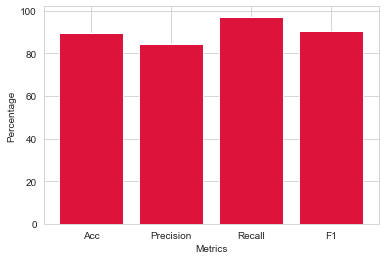

In [57]:
%matplotlib inline

x = ['Acc', 'Precision','Recall', 'F1']
metrics = [acc, precision, recall, f_score]
plt.gca().yaxis.grid(True)
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, metrics, color='crimson')
plt.xlabel("Metrics")
plt.ylabel("Percentage")
plt.xticks(x_pos, x)
plt.show()

**Let's save the results**

In [59]:
import joblib
joblib.dump(clf, 'appointments_prediction.joblib')

['appointments_prediction.joblib']